LightGBM

Generalized Additive Models (GAM) 

Convolutional Neural Networks (CNN) 

Long Short-Term Memory Networks (LSTM) 

Transformer-based Models

Wavenet

InceptionTime

In [31]:
import pandas as pd

In [32]:
df = pd.read_csv('./solar_weather_processed.csv')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Energy delta_Wh  196776 non-null  int64  
 1   GHI              196776 non-null  float64
 2   temp             196776 non-null  float64
 3   pressure         196776 non-null  float64
 4   humidity         196776 non-null  float64
 5   wind_speed       196776 non-null  float64
 6   rain_1h          196776 non-null  float64
 7   snow_1h          196776 non-null  float64
 8   clouds_all       196776 non-null  float64
 9   isDayTime        196776 non-null  int64  
 10  Year             196776 non-null  int64  
 11  Month_num        196776 non-null  int64  
 12  DayOfYear        196776 non-null  int64  
 13  Week             196776 non-null  int64  
 14  Minute           196776 non-null  int64  
 15  Hour             196776 non-null  int64  
 16  Season           196776 non-null  int6

In [34]:
import sklearn


In [35]:
print(sklearn.__version__)


1.6.1


# Seperate file for model buiding only


In [36]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error


In [37]:
# 6. Define X (features) and y (target)
FEATURES = [col for col in df.columns if col != 'Energy delta_Wh']
X = df[FEATURES]
y = df['Energy delta_Wh']

In [38]:
# 7. Time-based train-test split (80-20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

## Models

### XGboost, ligbtGBM

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 157420, number of used features: 29
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 566.950896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

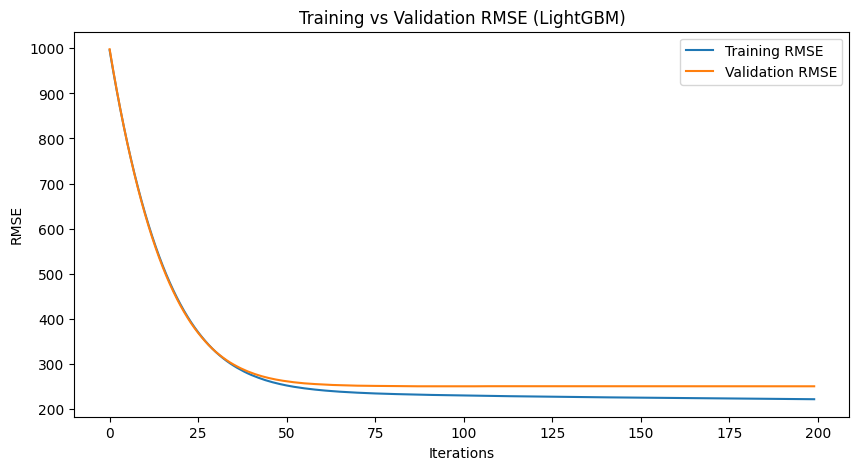

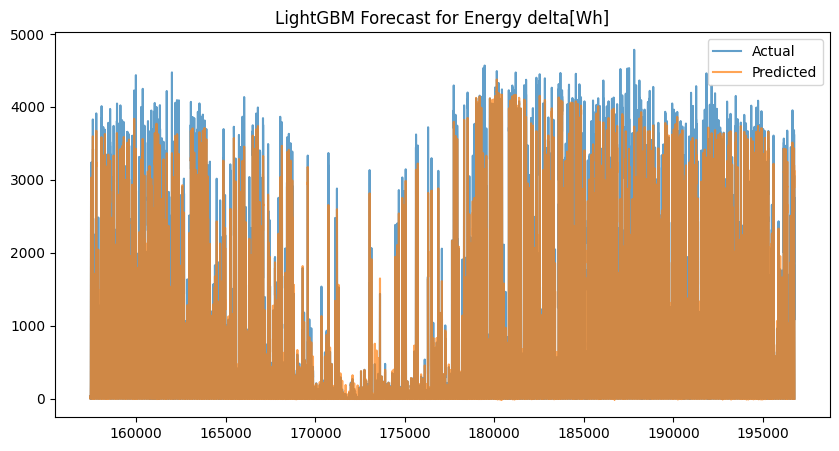

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, early_stopping, record_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8. Train LightGBM with monitoring
model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

evals_result = {}  # Dictionary to store training history

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",  # Use RMSE for evaluation
    callbacks=[record_evaluation(evals_result)]  # ✅ Fix: Store training history
)

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot Training Curve (to check overfitting)
plt.figure(figsize=(10, 5))
plt.plot(evals_result["training"]["rmse"], label="Training RMSE")  # ✅ Fix: "training" is now recorded
plt.plot(evals_result["valid_1"]["rmse"], label="Validation RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE (LightGBM)")
plt.legend()
plt.show()

# 12. Plot Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("LightGBM Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


### GAM

In [40]:
from pygam import LinearGAM, s

# Define GAM model with smooth terms for each feature
gam = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + 
    s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + 
    s(16)
).fit(X, y)

# Print model summary
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    212.5169
Link Function:                     IdentityLink Log Likelihood:                              -2510023.7981
Number of Samples:                       196776 AIC:                                          5020474.6301
                                                AICc:                                         5020475.0961
                                                GCV:                                           138516.5501
                                                Scale:                                         138247.3012
                                                Pseudo R-Squared:                                   0.8735
Feature Function                  Lam

C:\Users\User\AppData\Local\Temp\ipykernel_17600\1805592340.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test set
y_pred = gam.predict(X_test)

# Compute accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = (abs(y_test - y_pred) / y_test).mean() * 100

# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 235.3765
MSE: 156740.3032
RMSE: 395.9044
MAPE: inf%


### CNN

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# 3. Normalize Data (CNNs work better with scaled inputs)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

# 4. Reshape Data for CNN [Samples, Time Steps, Features]
TIME_STEPS = 10  # Number of previous time steps to use for prediction

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 5. Build CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 6. Train the Model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# 7. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 8. Evaluate the Model
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

# 9. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


Epoch 1/20
4920/4920 [==============================] - 14s 3ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 2/20
4920/4920 [==============================] - 12s 3ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 3/20
4920/4920 [==============================] - 12s 2ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 4/20
4920/4920 [==============================] - 15s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 5/20
4920/4920 [==============================] - 15s 3ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 6/20
4920/4920 [==============================] - 14s 3ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 7/20
4920/4920 [==============================] - 14s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/20
4920/4920 [==============================] - 14s 3ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 9/20
4920/4920 [==============================] - 14s 3ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 10/20
4920/4920 [==============================] - 14s 3ms/step - l

C:\Users\User\AppData\Local\Temp\ipykernel_17600\1712566322.py:53: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100


### LSTM

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

y_train_array = y_train.to_numpy().reshape(-1, 1)
y_test_array = y_test.to_numpy().reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_array)
y_test_scaled = scaler_y.transform(y_test_array)

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# 2. Create Sequences
TIME_STEPS = 10

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 3. Build a Deeper LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 4. Train the Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

# 5. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 6. Evaluate the Model
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = root_mean_squared_error(y_test_seq, y_pred)

# MAPE can be infinite if y_test_seq has zeros; consider SMAPE or filtering out zeros if needed
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


Epoch 1/20
4920/4920 [==============================] - 96s 19ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 2/20
4920/4920 [==============================] - 93s 19ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 3/20
4920/4920 [==============================] - 90s 18ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 4/20
4920/4920 [==============================] - 101s 21ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 5/20
4920/4920 [==============================] - 86s 17ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 6/20
4920/4920 [==============================] - 89s 18ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/20
4920/4920 [==============================] - 94s 19ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 8/20
4920/4920 [==============================] - 92s 19ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 9/20
4920/4920 [==============================] - 91s 18ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 10/20
4920/4920 [==============================] - 90s 18

C:\Users\User\AppData\Local\Temp\ipykernel_17600\929697950.py:70: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

y_train_array = y_train.to_numpy().reshape(-1, 1)
y_test_array = y_test.to_numpy().reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_array)
y_test_scaled = scaler_y.transform(y_test_array)

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# 2. Create Sequences
TIME_STEPS = 10

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 3. Build a Modified LSTM Model
model = Sequential([
    # Using a Bidirectional wrapper for the first LSTM layer
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(512, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='linear'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Callbacks: EarlyStopping and ModelCheckpoint to avoid overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# 4. Train the Model (increase epochs to let early stopping decide when to halt)
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,  # Increased epochs with early stopping in place
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=callbacks,
    verbose=1
)

# 5. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# 6. Evaluate the Model
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = root_mean_squared_error(y_test_seq, y_pred)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# (Optional) Plot the training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


Epoch 1/50
4920/4920 [==============================] - 773s 155ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 2/50
4920/4920 [==============================] - 688s 140ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 3/50
4920/4920 [==============================] - 632s 129ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/50
4920/4920 [==============================] - 625s 127ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/50
4920/4920 [==============================] - 651s 132ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/50
2112/4920 [===========>..................] - ETA: 5:29 - loss: 0.0034

## Transformer

In [44]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ...existing code...
# 1. Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

y_train_array = y_train.to_numpy().reshape(-1, 1)
y_test_array = y_test.to_numpy().reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_array)
y_test_scaled = scaler_y.transform(y_test_array)

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# 2. Create Sequences
TIME_STEPS = 10

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 3. Build a Simple Transformer Encoder Block
def transformer_encoder(inputs, d_model, num_heads, ff_dim, rate=0.1):
    # Map input features to d_model (e.g., 17 -> 64)
    x = Dense(d_model)(inputs)

    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attention_output = Dropout(rate)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attention_output)
    
    # Feed Forward
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return out2

d_model = 64  # Hidden size of the model
num_heads = 2  # Number of attention heads
ff_dim = 128   # Feed-forward layer dimension
dropout_rate = 0.2

inputs = Input(shape=(TIME_STEPS, X_train.shape[1]))
x = transformer_encoder(inputs, d_model, num_heads, ff_dim, dropout_rate)
x = transformer_encoder(x, d_model, num_heads, ff_dim, dropout_rate)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

# 4. Train the Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

# 5. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 6. Evaluate the Model
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = root_mean_squared_error(y_test_seq, y_pred)

mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


Epoch 1/20
4920/4920 [==============================] - 153s 30ms/step - loss: 0.0088 - val_loss: 0.0041
Epoch 2/20
4920/4920 [==============================] - 156s 32ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 3/20
4920/4920 [==============================] - 146s 30ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 4/20
4920/4920 [==============================] - 145s 29ms/step - loss: 0.0061 - val_loss: 0.0039
Epoch 5/20
4920/4920 [==============================] - 141s 29ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 6/20
4920/4920 [==============================] - 143s 29ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 7/20
4920/4920 [==============================] - 144s 29ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 8/20
4920/4920 [==============================] - 147s 30ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 9/20
4920/4920 [==============================] - 151s 31ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 10/20
4920/4920 [==============================] 

C:\Users\User\AppData\Local\Temp\ipykernel_17600\320902340.py:91: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100


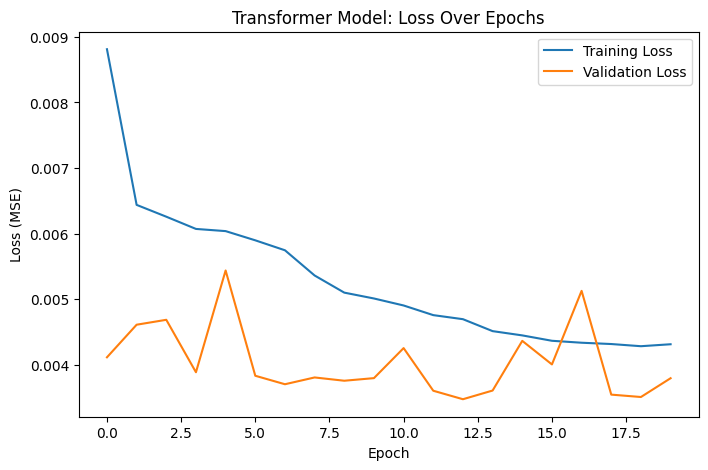

In [45]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Transformer Model: Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


In [46]:
import tensorflow as tf

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Give it a name so Keras can display it
root_mean_squared_error.__name__ = 'rmse'


Epoch 1/20
4920/4920 [==============================] - 145s 29ms/step - loss: 0.0043 - rmse: 0.0620 - val_loss: 0.0038 - val_rmse: 0.0413
Epoch 2/20
4920/4920 [==============================] - 127s 26ms/step - loss: 0.0043 - rmse: 0.0619 - val_loss: 0.0042 - val_rmse: 0.0446
Epoch 3/20
4920/4920 [==============================] - 122s 25ms/step - loss: 0.0043 - rmse: 0.0619 - val_loss: 0.0035 - val_rmse: 0.0394
Epoch 4/20
4920/4920 [==============================] - 121s 25ms/step - loss: 0.0043 - rmse: 0.0617 - val_loss: 0.0038 - val_rmse: 0.0401
Epoch 5/20
4920/4920 [==============================] - 121s 25ms/step - loss: 0.0043 - rmse: 0.0618 - val_loss: 0.0041 - val_rmse: 0.0428
Epoch 6/20
4920/4920 [==============================] - 131s 27ms/step - loss: 0.0042 - rmse: 0.0614 - val_loss: 0.0036 - val_rmse: 0.0388
Epoch 7/20
4920/4920 [==============================] - 123s 25ms/step - loss: 0.0043 - rmse: 0.0617 - val_loss: 0.0037 - val_rmse: 0.0438
Epoch 8/20
4920/4920 [=====

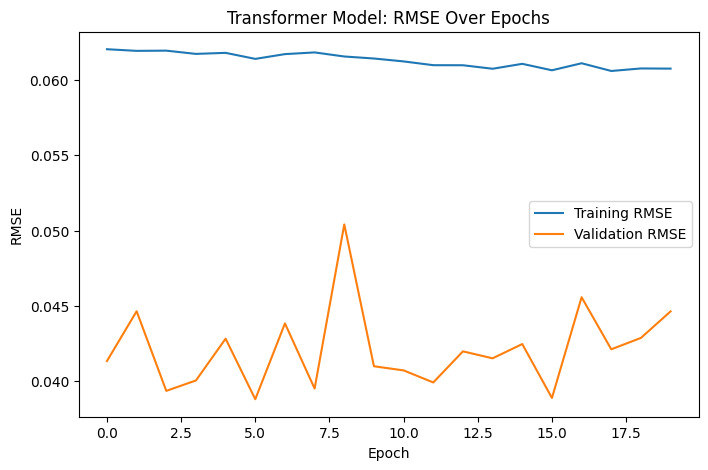

In [47]:
import matplotlib.pyplot as plt

import tensorflow as tf

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Give it a name so Keras can display it
root_mean_squared_error.__name__ = 'rmse'


model.compile(
    optimizer='adam',
    loss='mse',            # Primary loss for training
    metrics=[root_mean_squared_error]  # Track RMSE each epoch
)


history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)


plt.figure(figsize=(8, 5))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title("Transformer Model: RMSE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()


## InceptionTime

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# 1. Scale Data
# -----------------------------
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

y_train_array = y_train.to_numpy().reshape(-1, 1)
y_test_array = y_test.to_numpy().reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_array)
y_test_scaled = scaler_y.transform(y_test_array)

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# -----------------------------
# 2. Create Sequences
# -----------------------------
TIME_STEPS = 10

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# -----------------------------
# InceptionTime Modules
# -----------------------------
def inception_module(x, filters=32, kernel_sizes=[3, 5, 7], bottleneck=32):
    # Bottleneck to reduce dimensionality if input channels are large
    if bottleneck and x.shape[-1] > bottleneck:
        x = layers.Conv1D(bottleneck, 1, padding='same', activation='relu')(x)
    
    conv_branches = []
    for k in kernel_sizes:
        branch = layers.Conv1D(filters, k, padding='same', activation='relu')(x)
        conv_branches.append(branch)
    
    # MaxPool branch
    pool_branch = layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    pool_branch = layers.Conv1D(filters, 1, padding='same', activation='relu')(pool_branch)
    conv_branches.append(pool_branch)
    
    # Concatenate all branches
    x = layers.Concatenate()(conv_branches)
    x = layers.BatchNormalization()(x)
    return x

def build_inceptiontime(input_shape, num_modules=3, filters=32, kernel_sizes=[3, 5, 7]):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_modules):
        x = inception_module(x, filters=filters, kernel_sizes=kernel_sizes)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# -----------------------------
# 3. Build InceptionTime Model
# -----------------------------
inception_model = build_inceptiontime(
    input_shape=(TIME_STEPS, X_train.shape[1]),
    num_modules=3,      # number of inception modules
    filters=32,         # conv filters
    kernel_sizes=[3,5,7]  # different kernel sizes for multi-scale
)

# -----------------------------
# 4. Train the Model
# -----------------------------
history = inception_model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

# -----------------------------
# 5. Make Predictions
# -----------------------------
y_pred_scaled = inception_model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# -----------------------------
# 6. Evaluate the Model
# -----------------------------
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = root_mean_squared_error(y_test_seq, y_pred)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


Epoch 1/20
4920/4920 [==============================] - 64s 12ms/step - loss: 0.0091 - val_loss: 0.0046
Epoch 2/20
4920/4920 [==============================] - 58s 12ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 3/20
4920/4920 [==============================] - 57s 12ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 4/20
4920/4920 [==============================] - 57s 12ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 5/20
4920/4920 [==============================] - 58s 12ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 6/20
4920/4920 [==============================] - 58s 12ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 7/20
4920/4920 [==============================] - 58s 12ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
4920/4920 [==============================] - 58s 12ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 9/20
4920/4920 [==============================] - 58s 12ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 10/20
4920/4920 [==============================] - 58s 12m

C:\Users\User\AppData\Local\Temp\ipykernel_17600\1047172755.py:115: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100
